In [15]:
# Install dependencies if needed
!pip install tensorflow pandas numpy matplotlib zipfile36



In [16]:
import os
import numpy as np
import pandas as pd
import zipfile
import glob
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [5]:
from google.colab import files
files.upload()  # Upload kaggle.json


Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"shettynaisha","key":"685417dbc9d29c3584f3b5a11cdcefd3"}'}

In [6]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [7]:
!kaggle datasets download -d xhlulu/140k-real-and-fake-faces
!unzip 140k-real-and-fake-faces.zip


Streaming output truncated to the last 5000 lines.
  inflating: real_vs_fake/real-vs-fake/valid/real/34832.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34836.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34839.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34847.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34848.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34852.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34861.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34864.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34868.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34877.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34883.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34887.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34891.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34894.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34904.jpg  
  inflating: real_v

In [8]:
import os
print(os.listdir())  # List files and directories in the current path


['.config', 'test.csv', 'real_vs_fake', 'kaggle (1).json', 'train.csv', 'kaggle.json', '140k-real-and-fake-faces.zip', 'valid.csv', 'sample_data']


In [11]:
# Unzip dataset (Only run if the dataset is not extracted)
dataset_path = "140k-real-and-fake-faces.zip"
extract_path = "140k-real-and-fake-faces/"

if not os.path.exists(extract_path):
    with zipfile.ZipFile(dataset_path, "r") as zip_ref:
        zip_ref.extractall(extract_path)

# Verify extracted folders
print("Top-level directory:", os.listdir("140k-real-and-fake-faces"))
print("Inside real_vs_fake:", os.listdir("140k-real-and-fake-faces/real_vs_fake"))




Top-level directory: ['test.csv', 'real_vs_fake', 'train.csv', 'valid.csv']
Inside real_vs_fake: ['real-vs-fake']


In [12]:
# Load the dataset CSV
train_df = pd.read_csv("140k-real-and-fake-faces/train.csv")

# Fix image paths to match extracted dataset structure
train_df["image_path"] = "140k-real-and-fake-faces/real_vs_fake/real-vs-fake/" + train_df["path"]

# Verify if paths are correct
print(train_df.head())

# Check if first image exists
print("File exists:", os.path.exists(train_df["image_path"].iloc[0]))




   Unnamed: 0                                      original_path     id  \
0           0  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  31355   
1           1  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  02884   
2           2  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  33988   
3           3  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  53875   
4           4  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  24149   

   label label_str                  path  \
0      1      real  train/real/31355.jpg   
1      1      real  train/real/02884.jpg   
2      1      real  train/real/33988.jpg   
3      1      real  train/real/53875.jpg   
4      1      real  train/real/24149.jpg   

                                          image_path  
0  140k-real-and-fake-faces/real_vs_fake/real-vs-...  
1  140k-real-and-fake-faces/real_vs_fake/real-vs-...  
2  140k-real-and-fake-faces/real_vs_fake/real-vs-...  
3  140k-real-and-fake-faces/real_vs_fake/real-vs-...  
4  140k-r

In [13]:
# Define data augmentation for better model performance
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 80% training, 20% validation
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Create Training & Validation Data Generators
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="image_path",
    y_col="label_str",  # 'real' or 'fake'
    target_size=(128, 128),
    batch_size=32,
    class_mode="binary",
    subset="training"
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="image_path",
    y_col="label_str",
    target_size=(128, 128),
    batch_size=32,
    class_mode="binary",
    subset="validation"
)

# Check number of images loaded
print("Training samples:", train_generator.samples)
print("Validation samples:", validation_generator.samples)




Found 80000 validated image filenames belonging to 2 classes.
Found 20000 validated image filenames belonging to 2 classes.
Training samples: 80000
Validation samples: 20000


In [17]:
# Define CNN model architecture
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Helps prevent overfitting
    Dense(1, activation='sigmoid')  # Binary classification (real vs fake)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Show model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Train model for 10 epochs (adjust as needed)
epochs = 10

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 568s 224ms/step - accuracy: 0.6252 - loss: 0.6624 - val_accuracy: 0.1936 - val_loss: 0.8592
Epoch 2/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 491s 196ms/step - accuracy: 0.6520 - loss: 0.6249 - val_accuracy: 0.1432 - val_loss: 1.2608
Epoch 3/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 486s 194ms/step - accuracy: 0.6818 - loss: 0.5931 - val_accuracy: 0.7988 - val_loss: 0.4527
Epoch 4/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 487s 195ms/step - accuracy: 0.7178 - loss: 0.5508 - val_accuracy: 0.6665 - val_loss: 0.6268
Epoch 5/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 487s 195ms/step - accuracy: 0.7426 - loss: 0.5211 - val_accuracy: 0.6293 - val_loss: 0.6850
Epoch 6/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 486s 194ms/step - accuracy: 0.7601 - loss: 0.4986 - val_accuracy: 0.7062 - val_loss: 0.5876
Epoch 7/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 481s 192ms/step - accuracy: 0.7738 - loss: 0.4775 - val_accuracy: 0.6115 - val_loss: 0.7286
Epoch 8/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 481s 192ms/step - ac

In [19]:
# Evaluate model on validation data
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


625/625 ━━━━━━━━━━━━━━━━━━━━ 92s 147ms/step - accuracy: 0.5460 - loss: 0.8808
Validation Accuracy: 54.30%


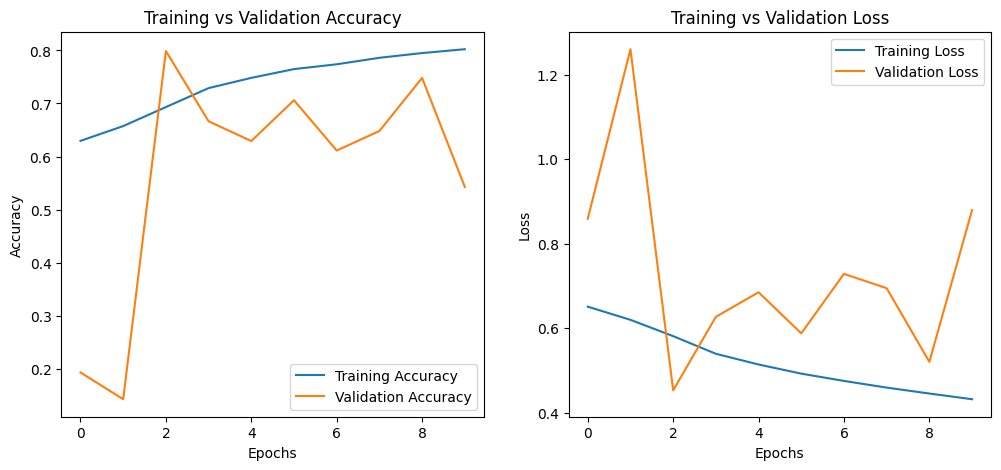

In [20]:
# Plot training accuracy and loss
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


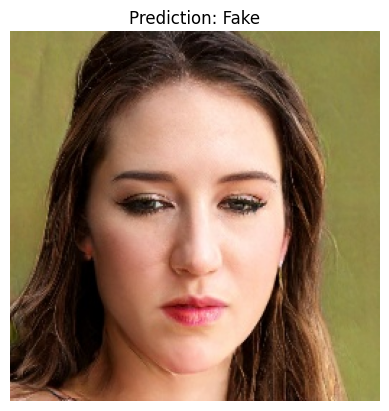

In [21]:
# Pick a random image from the dataset
img_path = train_df["image_path"].sample(1).values[0]

# Load and preprocess image
img = load_img(img_path, target_size=(128, 128))
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Predict using the trained model
prediction = model.predict(img_array)
result = "Real" if prediction[0][0] > 0.5 else "Fake"

# Show the image and prediction
plt.imshow(load_img(img_path))
plt.axis("off")
plt.title(f"Prediction: {result}")
plt.show()


In [26]:
import tensorflow as tf

# Load the old model (if it's working in Colab)
old_model = tf.keras.models.load_model("/content/deepfake_detector_model.h5")

# Re-save the model using a newer format
old_model.save("/content/deepfake_detector_model_new.h5", save_format="h5")

# Download the new model
from google.colab import files
files.download("/content/deepfake_detector_model_new.h5")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
from tensorflow.keras.models import load_model

# Load the trained model
loaded_model = load_model("deepfake_detector_model.h5")

# Test it on a new image (same as Step 8)
prediction = loaded_model.predict(img_array)
result = "Real" if prediction[0][0] > 0.5 else "Fake"
print(f"Loaded Model Prediction: {result}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
Loaded Model Prediction: Fake
